***
# <font color=red>Building a Forecaster using AutoMLx</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle AutoMLx Team </font></p>

***

Forecasting Demo notebook.

Copyright © 2025, Oracle and/or its affiliates.

Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl/

## Overview of this Notebook

In this notebook we will build a forecaster using the Oracle AutoMLx tool for three real-world datasets. We explore the various options available in the Oracle AutoMLx Forecasting module, allowing the user to control the AutoML training process. We finally evaluate the forecasting algorithms using in-built visualization tools. Finally, we provide an overview of the capabilities that Oracle AutoMLx offers for explaining the predictions of the tuned model.

---
## Prerequisites

  - Experience level: Novice (Python and Machine Learning)
  - Professional experience: Some industry experience
---

## Business Use

Forecasting uses historical time series data as input to make informed estimates of future trends. Learning an accurate forecasting model requires expertise in data science and statistics. This process typically comprises of:
- Preprocess dataset (clean, impute, engineer features, normalize).
- Pick an appropriate model for the given dataset and prediction task at hand.
- Tune the chosen model’s hyperparameters for the given dataset.

These steps are significantly time consuming and heavily rely on data scientist expertise. Unfortunately, to make this problem harder, the best feature subset, model, and hyperparameter choice widely varies with the dataset and the prediction task. Hence, there is no one-size-fits-all solution to achieve reasonably good model performance. Using a simple Python API, AutoML can quickly jump-start the datascience process with an accurately-tuned model and appropriate features for a given prediction task.

## Table of Contents

- <a href='#setup'>Setup</a>
- <a href='#load-m4'>Load the M4 Forecasting Competition dataset</a>
- <a href='#univariate'>Univariate time series (single-target forecasting)</a>
    - <a href='#task'>Split data into train and test for the forecasting task</a>
    - <a href='#Engine'>Setting the execution engine</a>
    - <a href='#provider'>Create an instance of Oracle AutoMLx</a>
    - <a href='#default'>Train a forecasting model using AutoMLx</a>
    - <a href='#forecast'>Generate and visualize forecasts</a>
    - <a href='#analysis'>Analyze the AutoML optimization process</a>
        - <a href='#algorithm-selection'>Algorithm Selection</a>
        - <a href='#hyperparameter-tuning'>Hyperparameter Tuning</a>
- <a href='#multi'>Multivariate time series</a>
    - <a href='#single-target'>Single-target Forecasting with Exogenous Variables</a>
    - <a href='#multi-target'>Multi-target Forecasting with Exogenous Variables</a>
      - <a href='#advanced'>Advanced AutoML Configuration</a>
      - <a href='#multi-fitting'>Train a model using Oracle AutoMLx</a>
      - <a href='#WFCV'>Specify the number of cross-validation (CV) folds</a>
      - <a href='#multi-making'>Make predictions</a>
      - <a href='#multi-visualization'>Visualization</a>
- <a href='#MLX'>Machine Learning Explainability (MLX)</a>
    - <a href='#MLX-initializing'>Initialize an MLExplainer</a>
    - <a href='#MLX-local'>Prediction Explanations (Comparative Feature Importance)</a>
- <a href='#ref'>References</a>

<a id='setup'></a>
## Setup

Basic setup for the Notebook.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Load the required modules.

In [2]:
import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
    from sktime.forecasting.model_selection import temporal_train_test_split
except ImportError:
    try:
        from sktime.split import TemporalTrainTestSplitter as temporal_train_test_split
    except ImportError as e:
        raise ImportError("Failed to import Splitters from sktime. "
                          "Please ensure you have the correct version of sktime installed.") from e

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["font.size"] = 15

import automlx
from automlx import init

<a id='load-m4'></a>
### Load the M4 Forecasting Competition dataset


We fetch the series from the repository of the [M4 forecasting competition](https://mofc.unic.ac.cy/m4/) to use throughout this demo.

In [3]:
! wget https://github.com/Mcompetitions/M4-methods/raw/master/Dataset/Train/Weekly-train.csv -q
! wget https://github.com/Mcompetitions/M4-methods/raw/master/Dataset/M4-info.csv -q

In [4]:

all_series = pd.read_csv("Weekly-train.csv", index_col=0)  # consists of thousands of series
metadata_csv = pd.read_csv("M4-info.csv", index_col=0)  # describes their datetime index

<a id='univariate'></a>
# Univariate time series (single-target forecasting)
The Oracle AutoMLx solution for forecasting can process both univariate (where only a single time series is available) and multivariate time series (where multiple time series are available). We start by displaying an example of use for univariate time series, and will address multivariate data at the end of this notebook.<br>

We select one time series from the finance sector with weekly collection frequency. M4 dataset requires additional preprocessing to reconstruct the time series.

In [5]:
series_id = "W142"
series_metadata = metadata_csv.loc[series_id]
series_values = all_series.loc[series_id]

# drop NaNs for the time period where data wasn't recorded
series_values.dropna(inplace=True)

# retrieve starting date of recording and series length to generate the datetime index
start_date = pd.to_datetime(series_metadata.StartingDate)
future_dates = pd.date_range(start=start_date, periods=len(series_values), freq="W")
y = pd.DataFrame(
    series_values.to_numpy(),
    index=future_dates,
    columns=[(series_metadata.category + "_" + series_id)],
)

We can now visualize the last 200 weeks of data we have on hand.

<Axes: ylabel='Weekly Series W142'>

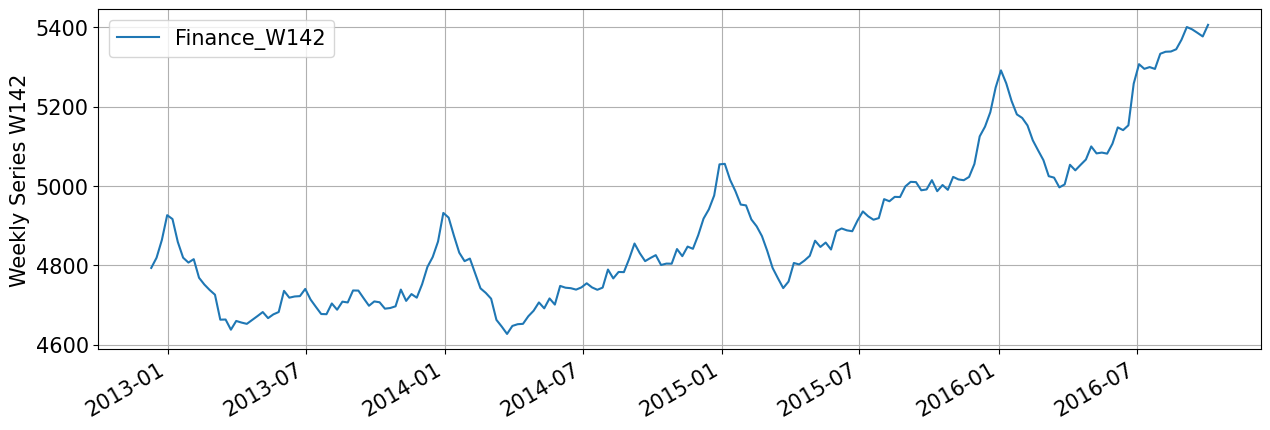

In [6]:
y = y.tail(n=200)  # approximately 4 years of data
y.plot(ylabel="Weekly Series " + series_id, grid=True)

One must ensure that the data points are in a Pandas DataFrame, sorted in chronological order.

In [7]:
print(y.index)
print("Time Index is", "" if y.index.is_monotonic_increasing else "NOT", "monotonic.")
print("Train datatype", type(y))

DatetimeIndex(['2012-12-09 12:00:00', '2012-12-16 12:00:00',
               '2012-12-23 12:00:00', '2012-12-30 12:00:00',
               '2013-01-06 12:00:00', '2013-01-13 12:00:00',
               '2013-01-20 12:00:00', '2013-01-27 12:00:00',
               '2013-02-03 12:00:00', '2013-02-10 12:00:00',
               ...
               '2016-07-31 12:00:00', '2016-08-07 12:00:00',
               '2016-08-14 12:00:00', '2016-08-21 12:00:00',
               '2016-08-28 12:00:00', '2016-09-04 12:00:00',
               '2016-09-11 12:00:00', '2016-09-18 12:00:00',
               '2016-09-25 12:00:00', '2016-10-02 12:00:00'],
              dtype='datetime64[ns]', length=200, freq='W-SUN')
Time Index is  monotonic.
Train datatype <class 'pandas.core.frame.DataFrame'>


<a id='task'></a>
### Split data into train and test for the forecasting task
As can be seen above, the data contains 100 weekly recorded values over the past 4 years. We will try to predict electricity consumption for the last 0.5 year of data (26 data points), using the previous years as training data. Hence, we separate the dataset into training and testing sets using Temporal train-test split, which ensures that the continuity of the input time series is preserved. Each point in the series represents a month, so we will hold out the last 26 points as test data.

In [8]:
y_train, y_test = temporal_train_test_split(y, test_size=26)
print("Training length: ", len(y_train), " Testing length: ", len(y_test))

Training length:  174  Testing length:  26


In [9]:
print("y_train", y_train)
print("\ny_test", y_test)

y_train                      Finance_W142
2012-12-09 12:00:00      4793.269
2012-12-16 12:00:00      4818.969
2012-12-23 12:00:00      4863.783
2012-12-30 12:00:00      4926.357
2013-01-06 12:00:00      4916.616
...                           ...
2016-03-06 12:00:00      5024.759
2016-03-13 12:00:00      5021.153
2016-03-20 12:00:00      4996.524
2016-03-27 12:00:00      5004.032
2016-04-03 12:00:00      5053.536

[174 rows x 1 columns]

y_test                      Finance_W142
2016-04-10 12:00:00      5039.544
2016-04-17 12:00:00      5053.420
2016-04-24 12:00:00      5066.860
2016-05-01 12:00:00      5099.887
2016-05-08 12:00:00      5082.291
2016-05-15 12:00:00      5084.340
2016-05-22 12:00:00      5081.651
2016-05-29 12:00:00      5106.797
2016-06-05 12:00:00      5147.906
2016-06-12 12:00:00      5140.993
2016-06-19 12:00:00      5153.210
2016-06-26 12:00:00      5258.369
2016-07-03 12:00:00      5307.455
2016-07-10 12:00:00      5295.631
2016-07-17 12:00:00      5300.088
2016-07-

<a id='Engine'></a>
### Setting the execution engine
The AutoML pipeline offers the function `init`, which allows to initialize the parallelization engine.

In [10]:
init(engine="ray")

[2025-05-22 05:16:38,343] [automlx.backend] Overwriting ray session directory to /tmp/z9fyq_g2/ray, which will be deleted at engine shutdown. If you wish to retain ray logs, provide _temp_dir in ray_setup dict of engine_opts when initializing the AutoMLx engine.


<a id='provider'></a>
### Create an instance of Oracle AutoMLx

The Oracle AutoMLx solution automatically provides a tuned forecasting pipeline that best models the given training dataset and a prediction task at hand. Here the dataset can be any univariate time-series.

AutoML for Forecasting consists of three main modules:
- **Preprocessing**
    - Impute any missing values using back fill or forward fill mechanisms to ensure input has a well-defined and consistent frequency.
    - Identify seasonalities present in the data by detrending and analyzing the Autocorrelation Function (ACF) of the series.
    - Decide appropriate number of cross-validation (CV) folds and the forecast horizons based on the datetime frequency of data.
- **Algorithm Selection**: Identify the right algorithm for a given dataset, choosing from the following:
    - NaiveForecaster - Naive and Seasonal Naive method
    - ThetaForecaster - Equivalent to Simple Exponential Smoothing (SES) with drift
    - ExpSmoothForecaster - Holt-Winters' damped method
    - STLwESForecaster - Seasonal Trend LOESS (locally weighted smoothing) with Exponential Smoothing substructure
    - STLwARIMAForecaster - Seasonal Trend LOESS (locally weighted smoothing) with ARIMA substructure
    - SARIMAXForecaster - Seasonal Autoregressive Integrated Moving Average
    - ETSForecaster - Error, Trend, Seasonality (ETS) Statespace Exponential Smoothing
    - ProphetForecaster (optional) - Facebook Prophet, only available when explicitly provided to the AutoML Pipeline through the model_list parameter.
    - VARMAXForecaster - Vector AutoRegressive Moving Average with Exogenous Variables (Available for multi-target forecasting)
    - DynFactorForecaster - Dynamic Factor Models in state-space form with Exogenous Variables (Available for multi-target forecasting)
    - ExtraTreesForecaster - A reduction-based machine learning model based on ExtraTrees regression model
    - LGBMForecaster - A reduction-based machine learning model based on LGBM regression model
    - XGBForecaster - A reduction-based machine learning model based on XGB regression model
- **Hyperparameter Tuning**
    - Find the right model parameters that maximize score for the given dataset.

These pieces are readily combined into a simple AutoML pipeline which automates the entire forecasting process with minimal user input/interaction. One can then evaluate and visualize the forecast produced by the selected model, and optionally the other tuned models.

<a id='default'></a>
### Train a forecasting model using Oracle AutoMLx

The AutoML API is quite simple to work with. We first create an instance of the pipeline. Next, the training data is passed to the `fit()` function which successively executes the previously mentioned modules.

The generated model can then be used for forecasting tasks. By default, we use the negative of symmetric mean absolute percentage error (sMAPE)  scoring metric to evaluate the model performance

In [11]:
est1 = automlx.Pipeline(task="forecasting", n_algos_tuned=2)
est1.fit(X=None, y=y_train)

print("Selected model: {}".format(est1.selected_model_))
print("Selected model params: {}".format(est1.selected_model_params_))

[2025-05-22 05:16:43,535] [automlx.data_transform] Number of simple differencing orders required: d = 1


[2025-05-22 05:16:43,538] [automlx.data_transform] Seasonal Periodicities; from decomposed/adjusted: [52, 35, 1]


[2025-05-22 05:16:43,603] [automlx.interface] Dataset shape: (174,2)


[2025-05-22 05:16:46,294] [sanerec.autotuning.parameter] Hyperparameter epsilon autotune range is set to its validation range. This could lead to long training times


[2025-05-22 05:16:46,611] [sanerec.autotuning.parameter] Hyperparameter repeat_quality_threshold autotune range is set to its validation range. This could lead to long training times


[2025-05-22 05:16:46,617] [sanerec.autotuning.parameter] Hyperparameter scope autotune range is set to its validation range. This could lead to long training times


[2025-05-22 05:16:46,714] [automlx.data_transform] Running preprocessing. Number of features: 3


[2025-05-22 05:16:46,800] [automlx.data_transform] Preprocessing completed. Took 0.087 secs


[2025-05-22 05:16:46,810] [automlx.process] Running Model Generation


[2025-05-22 05:16:46,860] [automlx] Provided model (VARMAXForecaster) is not supported.Supported models are: ['LGBMForecaster', 'ExtraTreesForecaster', 'ExpSmoothForecaster', 'NaiveForecaster', 'SARIMAXForecaster', 'STLwARIMAForecaster', 'ThetaForecaster', 'ProphetForecaster', 'ETSForecaster', 'STLwESForecaster', 'XGBForecaster']


[2025-05-22 05:16:46,860] [automlx] Provided model (DynFactorForecaster) is not supported.Supported models are: ['LGBMForecaster', 'ExtraTreesForecaster', 'ExpSmoothForecaster', 'NaiveForecaster', 'SARIMAXForecaster', 'STLwARIMAForecaster', 'ThetaForecaster', 'ProphetForecaster', 'ETSForecaster', 'STLwESForecaster', 'XGBForecaster']


[2025-05-22 05:16:46,861] [automlx.process] Model Generation completed.


[2025-05-22 05:16:46,930] [automlx.model_selection] Running Model Selection


[2025-05-22 05:16:50,911] [automlx.dataset] Forecast horizon set to 13 for validation sets.


[2025-05-22 05:17:05,408] [automlx.model_selection] Model Selection completed - Took 18.478 sec - Selected models: [['ETSForecaster', 'STLwARIMAForecaster']]


[2025-05-22 05:17:05,494] [automlx.trials] Running Model Tuning for ['ETSForecaster']


[2025-05-22 05:17:05,566] [automlx.dataset] Forecast horizon set to 13 for validation sets.


[2025-05-22 05:17:13,983] [automlx.trials] Best parameters for ETSForecaster: {'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 52, 'initialization_method': 'estimated', 'initial_level': None, 'initial_trend': None, 'initial_seasonal': None, 'bounds': None, 'dates': None, 'freq': None, 'missing': 'none', 'start_params': None, 'maxiter': 1500, 'disp': -1, 'return_params': False}


[2025-05-22 05:17:13,985] [automlx.trials] Model Tuning completed. Took: 8.490 secs


[2025-05-22 05:17:14,202] [automlx.trials] Running Model Tuning for ['STLwARIMAForecaster']


[2025-05-22 05:17:14,287] [automlx.dataset] Forecast horizon set to 13 for validation sets.


[2025-05-22 05:17:17,083] [automlx.trials] Best parameters for STLwARIMAForecaster: {'seasonal_deg': 1, 'trend_deg': 1, 'low_pass_deg': 1, 'period': 52, 'arima_p': 2, 'arima_d': 1, 'arima_q': 2, 'arima_trend': 'n', 'concentrate_scale': True}


[2025-05-22 05:17:17,084] [automlx.trials] Model Tuning completed. Took: 2.881 secs


[2025-05-22 05:17:18,994] [automlx.interface] Re-fitting pipeline


[2025-05-22 05:17:19,016] [automlx.final_fit] Skipping updating parameter seed, already fixed by FinalFit_5439e7f1-c


[2025-05-22 05:17:20,802] [automlx.interface] AutoMLx completed.


Selected model: ETSForecaster
Selected model params: {'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 52, 'initialization_method': 'estimated', 'initial_level': None, 'initial_trend': None, 'initial_seasonal': None, 'bounds': None, 'dates': None, 'freq': None, 'missing': 'none', 'start_params': None, 'maxiter': 1500, 'disp': -1, 'return_params': False}


<a id='forecast'></a>
### Generating and visualizing forecasts
There are two interfaces that support generating future forecasts using the trained forecasting pipeline.
The preferred function, `forecast()`, accepts a user-input value for the number of periods to forecast into the future, i.e., relative to the end of the training series. It also accepts a significance level to generate prediction confidence intervals (CIs). When the methods support intervals, confidence intervals at 1-alpha are generated, for example, significance level alpha=0.05 generates 95% confidence intervals.

In [12]:
predictions = est1.forecast(periods=len(y_test), alpha=0.05)

[2025-05-22 05:17:22,400] [automlx.model] Forecast called on ETSForecaster that's not been fitted.


The `predict(X)` interface supports absolute index-based forecasts, but does not support confidence intervals (CIs). It also downcasts the index to int64.

It should be utilized only when you want to get both in-sample predictions (predictions at timestamps that are part of the training set) and out-of-sample predictions (predictions at timestamps that are not in the training set). The X variable should be an empty dataframe containing only the requested timestamps as index. Here we request 5 in-sample model fit values and 5 out-of-sample forecasts.

In [13]:
future_index = y_train.index[-5:].union(y_test.index[:5])
print(future_index)

DatetimeIndex(['2016-03-06 12:00:00', '2016-03-13 12:00:00',
               '2016-03-20 12:00:00', '2016-03-27 12:00:00',
               '2016-04-03 12:00:00', '2016-04-10 12:00:00',
               '2016-04-17 12:00:00', '2016-04-24 12:00:00',
               '2016-05-01 12:00:00', '2016-05-08 12:00:00'],
              dtype='datetime64[ns]', freq='W-SUN')


In [14]:
est1.predict(X=pd.DataFrame(index=future_index))

[2025-05-22 05:17:22,523] [automlx.model] Predict called on ETSForecaster that's not been fitted.


Finance_W142
2016-03-06 12:00:00   5015.306711
2016-03-13 12:00:00   5013.432026
2016-03-20 12:00:00   4998.150861
2016-03-27 12:00:00   5013.397612
2016-04-03 12:00:00   5028.193875
2016-04-10 12:00:00   5052.535771
2016-04-17 12:00:00   5066.283916
2016-04-24 12:00:00   5079.054044
2016-05-01 12:00:00   5102.910187
2016-05-08 12:00:00   5088.244409

AutoML provides a simple one-line tool to visualize forecasts and confidence intervals.

In [15]:
est1.plot_forecast(predictions=predictions, additional_frames=dict(y_test=y_test))

<a id='analysis'></a>
### Analyze the AutoML optimization process
During the AutoML process, a summary of the optimization process is logged. It consists of:
- Information about the training data
- Information about the AutoML Pipeline, such as:
    - selected features that AutoML found to be most predictive in the training data;
    - selected algorithm that was the best choice for this data;
    - hyperparameters for the selected algorithm.

AutoML provides a `print_summary()` API to output all the different trials performed.

In [16]:
est1.print_summary()

We also provide the capability to visualize the results of each stage of the AutoML pipeline.

<a id='algorithm-selection'></a>
#### Algorithm Selection

The plot below shows the scores predicted by Algorithm Selection for each algorithm. Since negative sMAPE is used by default, higher values (closer to zero) are better. The horizontal line shows the average score across all algorithms. Algorithms with better score than average are colored turquoise, whereas those with worse score than average are colored teal.

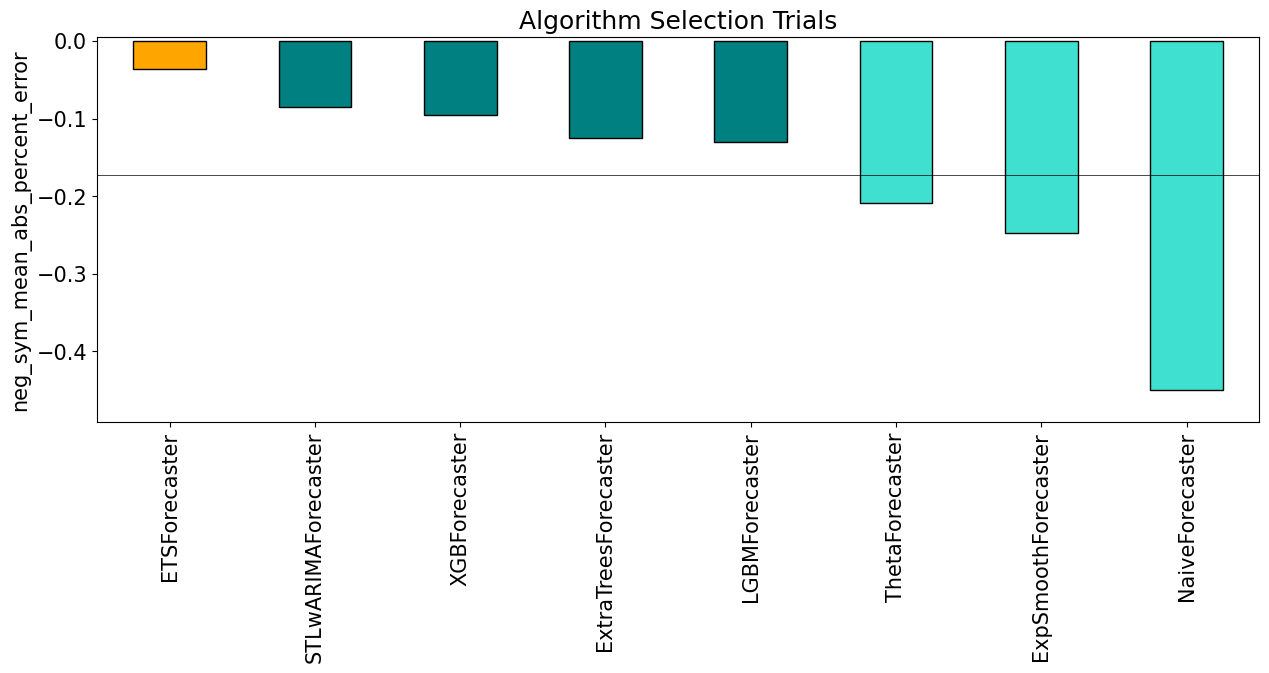

In [17]:
# Each trial is a tuple of
# (algorithm, no. samples, no. features, mean CV score, hyperparameters,
# all CV scores, total CV time (s), memory usage (Gb))
trials = est1.completed_trials_summary_[
    est1.completed_trials_summary_["Step"].str.contains("Model Selection")
]
name_of_score_column = f"Score ({est1._inferred_score_metric[0].name})"
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace=True)
scores = trials[name_of_score_column].tolist()
models = trials["Algorithm"].tolist()
colors = []

y_margin = 0.10 * (max(scores) - min(scores))
s = pd.Series(scores, index=models).sort_values(ascending=False)
s = s.dropna()
for f in s.keys():
    if f.strip() == est1.selected_model_.strip():
        colors.append("orange")
    elif s[f] >= s.mean():
        colors.append("teal")
    else:
        colors.append("turquoise")


fig, ax = plt.subplots(1)
ax.set_title("Algorithm Selection Trials")
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.set_ylabel(est1._inferred_score_metric[0].name)
s.plot.bar(ax=ax, color=colors, edgecolor="black")
ax.axhline(y=s.mean(), color="black", linewidth=0.5)
plt.show()

<a id='hyperparameter-tuning'></a>
#### Hyperparameter Tuning

Hyperparameter tuning is the last stage of the Oracle AutoMLx pipeline, and focuses on improving the chosen algorithm's score. We use a novel algorithm to search across many hyperparameter dimensions, and converge automatically when optimal hyperparameters are identified. Each trial in the graph below represents a particular hyperparameter combination for the selected model.

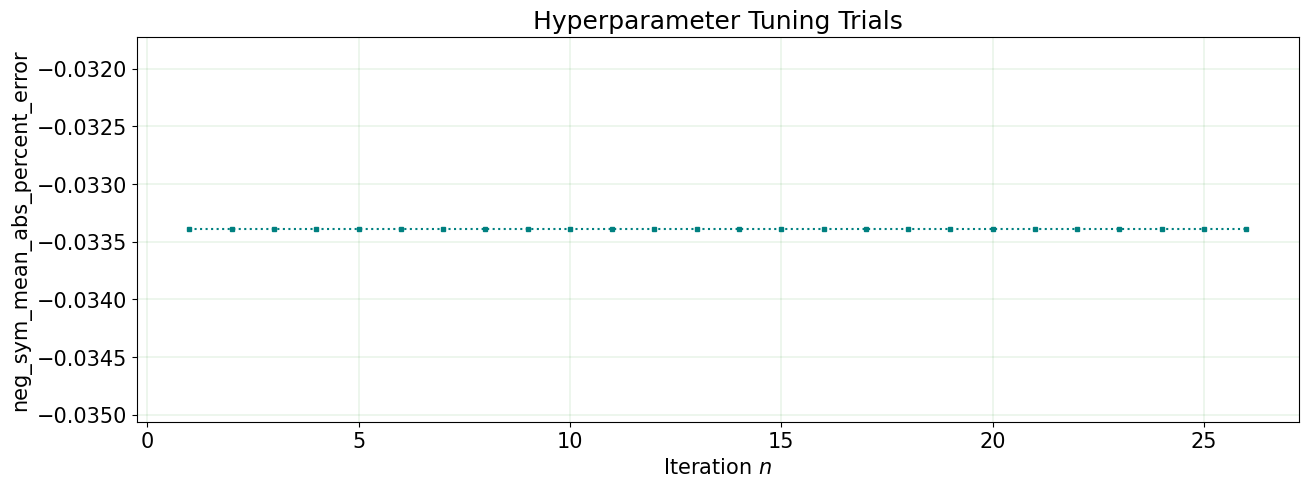

In [18]:
# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est1.completed_trials_summary_[
    est1.completed_trials_summary_["Step"].str.contains("Model Tuning")
]
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace=True)
trials.drop(trials[trials["Finished"] == -1].index, inplace=True)
trials["Finished"] = trials["Finished"].apply(
    lambda x: time.mktime(datetime.datetime.strptime(x, "%a %b %d %H:%M:%S %Y").timetuple())
)
trials.sort_values(by=["Finished"], ascending=True, inplace=True)
scores = trials[name_of_score_column].tolist()
score = []
score.append(scores[0])
for i in range(1, len(scores)):
    if scores[i] >= score[i - 1]:
        score.append(scores[i])
    else:
        score.append(score[i - 1])
y_margin = 0.10 * (max(score) - min(score))

fig, ax = plt.subplots(1)
ax.set_title("Hyperparameter Tuning Trials")
ax.set_xlabel("Iteration $n$")
ax.set_ylabel(est1._inferred_score_metric[0].name)
ax.grid(color="g", linestyle="-", linewidth=0.1)
ax.set_ylim(min(score) - y_margin, max(score) + y_margin)
ax.plot(range(1, len(trials) + 1), score, "k:", marker="s", color="teal", markersize=3)
plt.show()

We can also view all tuned algorithms, as well as their validation and testing performance. This provides a good sanity check for the decision making.


In [19]:
print(f"### Plotting is enabled for total models tuned = {len(est1.pipelines_)}.")
print("### Model_name\t\t Val_score ")

for pipeline in est1.pipelines_:
    print(
        pipeline.selected_model_,
        " \t",
        "%.4f"
        % est1.completed_trials_summary_[est1.completed_trials_summary_["Algorithm"] == pipeline.selected_model_].iloc[0][name_of_score_column],
        "\t",  # validation_score
    )
    predictions = pipeline.forecast(periods=len(y_test), alpha=0.05)  # out-of-sample forecast
    predictions.index = y_test.index
    fig = pipeline.plot_forecast(predictions=predictions, additional_frames=dict(y_test=y_test))
    fig.show()

### Plotting is enabled for total models tuned = 2.
### Model_name		 Val_score 
ETSForecaster  	 -0.0361 	
[2025-05-22 05:17:23,818] [automlx.model] Forecast called on ETSForecaster that's not been fitted.


STLwARIMAForecaster  	 -0.0855 	


<a id='multi'></a>
# Multivariate time series

We now display the use of the Oracle AutoMLx solution for multivariate time series.

There are two types of multivariate time series in forecasting:
- Single-target forecasting, with additional variables
- Multi-target forecasting, with or without additional variables

A time series target is the variable that the forecaster will try to predict. Additional variables provide more information that help with the prediction of the target.
In single-target forecasting, we are forecasting a single variable, whereas in multi-target forecasting, we forecast values of highly correlated variables together as a system.

We will first see an example of single-target forecasting with additional variables and then a second example with a multi-target forecasting problem.

<a id='single-target'></a>
## Single-target Forecasting with Exogenous Variables

We will now take two time series from the M4 dataset: one target variable, and one additional variable used solely as explanatory variables.
Note that $X$ consists of the additional variables ('W142') while $y$ has the target variables ('W143').
We will also showcase AutoML's functionality in the absence of a datetime index, by dropping the datetime index and utilize the series with only an int64index.

In [20]:
series_ids = ["W142", "W143"]
series_values = all_series.loc[series_ids].T

# drop NaNs for the time period where data wasn't recorded
series_values.dropna(inplace=True)

# we will take the first 100 elements of the series
series_values = series_values[:100]

# retrieve starting date of recording and series length to generate the datetime index
start_date = "28-06-00 12:00"
future_dates = pd.date_range(start=start_date, periods=len(series_values), freq="W")
data = pd.DataFrame(series_values.to_numpy(), index=future_dates, columns=series_ids)
data.index = np.arange(0, len(data))

y = pd.DataFrame(data["W142"])
X = pd.DataFrame(data["W143"])

We then split it using a temporal train-test split as done previously.

In [21]:
X_train_df, X_test_df = temporal_train_test_split(X, train_size=0.9)
y_train_df, y_test_df = temporal_train_test_split(y, train_size=0.9)

We will now fit the pipeline on this data. For the single-target forecasting task with additional variables, the pipeline considers all available models by default. However, the models that actually support additional variables are the following:
- `LGBMForecaster`
- `ExtraTreesForecaster`
- `XGBForecaster`
- `SARIMAXForecaster`
- `ProphetForecaster`
These models also have the option to discard additional variables. This can be set as a boolean hyperparameter called `use_X`.

In [22]:
est2 = automlx.Pipeline(
    task="forecasting",
    model_list=[
        "LGBMForecaster",
        "ExtraTreesForecaster",
        "XGBForecaster",
        "SARIMAXForecaster",
        "ProphetForecaster",
    ],
)
est2.fit(X=X_train_df, y=y_train_df)

print("Selected model: {}".format(est2.selected_model_))
print("Selected model params: {}".format(est2.selected_model_params_))

[2025-05-22 05:17:24,162] [automlx.data_transform] Number of simple differencing orders required: d = 0


[2025-05-22 05:17:24,164] [automlx.data_transform] Seasonal Periodicities; from decomposed/adjusted: [1]


[2025-05-22 05:17:24,235] [automlx.interface] Dataset shape: (90,3)


[2025-05-22 05:17:24,342] [automlx.data_transform] Running preprocessing. Number of features: 4


[2025-05-22 05:17:24,449] [automlx.data_transform] Preprocessing completed. Took 0.107 secs


[2025-05-22 05:17:24,490] [automlx.process] Running Model Generation


[2025-05-22 05:17:24,536] [automlx] Provided model (SARIMAXForecaster) is not supported.Supported models are: ['LGBMForecaster', 'ExtraTreesForecaster', 'ExpSmoothForecaster', 'NaiveForecaster', 'ThetaForecaster', 'ETSForecaster', 'XGBForecaster']


[2025-05-22 05:17:24,536] [automlx] Provided model (ProphetForecaster) is not supported.Supported models are: ['LGBMForecaster', 'ExtraTreesForecaster', 'ExpSmoothForecaster', 'NaiveForecaster', 'ThetaForecaster', 'ETSForecaster', 'XGBForecaster']


[2025-05-22 05:17:24,538] [automlx.process] Model Generation completed.


[2025-05-22 05:17:24,590] [automlx.model_selection] Running Model Selection


[2025-05-22 05:17:30,685] [automlx.model_selection] Model Selection completed - Took 6.095 sec - Selected models: [['XGBForecaster']]


[2025-05-22 05:17:30,758] [automlx.trials] Running Model Tuning for ['XGBForecaster']


[2025-05-22 05:17:45,375] [automlx.trials] Best parameters for XGBForecaster: {'differencing_order': 1, 'acf_local_maxima': '[4, 9, 18, 22, 14, 31, 26, 12, 1]', 'use_X': True, 'n_estimators': 16, 'max_depth': 2}


[2025-05-22 05:17:45,376] [automlx.trials] Model Tuning completed. Took: 14.618 secs


[2025-05-22 05:17:45,790] [automlx.interface] Re-fitting pipeline


[2025-05-22 05:17:45,801] [automlx.final_fit] Skipping updating parameter seed, already fixed by FinalFit_3b050512-1


[2025-05-22 05:17:48,871] [automlx.interface] AutoMLx completed.


Selected model: XGBForecaster
Selected model params: {'differencing_order': 1, 'acf_local_maxima': '[4, 9, 18, 22, 14, 31, 26, 12, 1]', 'use_X': True, 'n_estimators': 16, 'max_depth': 2}


<a id='multi-target'></a>
## Multi-target Forecasting with Exogenous Variables

For this use case, we now take 3 variables from the M4 dataset: two target variables (`W142`, `W143`) and one additional variables (`W141`). We will add a constant variable as an additional variable, so we have a total of two additional variables. We then split the data using a temporal train-test split and drop the datetime index, as done previously,

In [23]:
series_ids = ["W141", "W142", "W143"]
series_values = all_series.loc[series_ids].T

# drop NaNs for the time period where data wasn't recorded
series_values.dropna(inplace=True)
# we will take the first 100 elements of the series
series_values = series_values[:100]


# retrieve starting date of recording and series length to generate the datetime index
start_date = "28-06-00 12:00"
future_dates = pd.date_range(start=start_date, periods=len(series_values), freq="W")
data = pd.DataFrame(series_values.to_numpy(), index=future_dates, columns=series_ids)
data.index = np.arange(0, len(data))

y = data[["W142", "W143"]]
X = pd.DataFrame(data["W141"])
# adding the constant variable
X["const"] = 1

X_train_df, X_test_df = temporal_train_test_split(X, train_size=0.9)
y_train_df, y_test_df = temporal_train_test_split(y, train_size=0.9)

<a id='advanced'></a>
### Advanced AutoML Configuration

You can also configure the pipeline with suitable parameters according to your needs.
For the Multi-target forecasting task, the pipeline only considers two models : `VARMAX` and `DynFactor`.

In [24]:
custom_pipeline = automlx.Pipeline(
    task="forecasting",  # Supports 'classification', regression', 'anomaly_detection' and 'forecasting'
    model_list=[  # Specify the models you want the AutoMLx to consider
        "DynFactorForecaster",
        "VARMAXForecaster",
    ],
    n_algos_tuned=2,  # Choose how many models to tune
    preprocessing=True,  # Disable or enable Preprocessing step. Default to `True`
    search_space={},  # You can specify the hyper-parameters and ranges we search
    max_tuning_trials=2,  # The maximum number of tuning trials. Can be integer or Dict (max number for each model)
    score_metric="neg_sym_mean_abs_percent_error",  # Any scikit-learn metric or a custom function
    time_series_period=None,  # The period of time series
)

<a id='WFCV'></a>
### Specify the number of cross-validation (CV) folds
AutoML automatically decides how many folds to create, given the length of the input series. This is dependent on the frequency and length of the series.
In the above, the preprocessor chose to create two folds. In the following we set the number of folds to 8.

In [25]:
custom_pipeline.fit(X=X_train_df, y=y_train_df, cv=8)

[2025-05-22 05:17:49,513] [automlx.data_transform] Number of simple differencing orders required: d = 0


[2025-05-22 05:17:49,515] [automlx.data_transform] Seasonal Periodicities; from decomposed/adjusted: [1]


[2025-05-22 05:17:49,600] [automlx.interface] Dataset shape: (90,5)


[2025-05-22 05:17:49,641] [automlx.interface] Model Tune disabled.


[2025-05-22 05:17:49,711] [automlx.data_transform] Running preprocessing. Number of features: 6


[2025-05-22 05:17:49,823] [automlx.data_transform] Preprocessing completed. Took 0.111 secs


[2025-05-22 05:17:49,873] [automlx.process] Running Model Generation


[2025-05-22 05:17:49,913] [automlx.process] Model Generation completed.


[2025-05-22 05:17:49,972] [automlx.model_selection] Running Model Selection


[2025-05-22 05:17:49,972] [automlx.trials] Fewer models (2) than top_k (2) provided, skipping...


[2025-05-22 05:17:50,044] [automlx.interface] Re-fitting pipeline


[2025-05-22 05:17:50,061] [automlx.final_fit] Skipping updating parameter seed, already fixed by FinalFit_fa016e40-2


[2025-05-22 05:17:51,918] [automlx.interface] AutoMLx completed.


The AutoML pipeline provides attributes to get the selected features, the chosen model, hyperparameters as well as the score on the test set.

In [26]:
test_score = custom_pipeline.score(X=X_test_df, y=y_test_df)

print("Ranked models: {}".format(custom_pipeline.ranked_models_))
print("Selected model: {}".format(custom_pipeline.selected_model_))
print("Selected model params: {}".format(custom_pipeline.selected_model_params_))
print(f"Score on test data : {test_score}")

[2025-05-22 05:17:52,159] [automlx.model] Predict called on DynFactorForecaster that's not been fitted.


Ranked models: ['DynFactorForecaster', 'VARMAXForecaster']
Selected model: DynFactorForecaster
Selected model params: {'k_factors': 1, 'error_order': 2, 'factor_order': 2, 'error_cov_type': 'diagonal', 'use_X': True, 'error_var': False, 'enforce_stationarity': True}
Score on test data : -0.45821993166134833


<a id='multi-making'></a>
### Make predictions

As mention in the univariate data case, there are two ways of making a prediction :
- `forecast(k)` allows one to predict k steps after the end of the training data. It should be used when one wants to make out-of-sample predictions
- `predict(X)` returns predictions at the timestamps given as argument. It should be used when one wants to make in-sample predictions and out-of-sample predictions. It does not support confidence intervals.

In the cell below `predict()` is used on the last 5 timestamps of the train set, and all timestamps of the test set. `forecast()` is used to predict k steps after the training set, where k is the size of the test set.

In [27]:
y_pred = custom_pipeline.predict(pd.concat([X_train_df[-5:0], X_test_df], axis=0))
y_forecast = custom_pipeline.forecast(
    len(y_test_df), alpha=0.8, X=X_test_df
)  # out-of-sample forecast

[2025-05-22 05:17:52,258] [automlx.model] Predict called on DynFactorForecaster that's not been fitted.


[2025-05-22 05:17:52,279] [automlx.model] Forecast called on DynFactorForecaster that's not been fitted.


The obtained forecast contains predictions for the two target variables, as well as lower and upper confidence intervals, for each timestamp in the test set.

In [28]:
y_forecast

W142         W143  W142_ci_lower  W142_ci_upper
90  1525.364311  4120.705204    1516.139510    1534.589111
91  1532.862846  4110.992426    1519.246154    1546.479538
92  1522.772589  4118.850533    1506.048922    1539.496256
93  1520.196238  4119.049832    1501.057987    1539.334490
94  1520.707582  4115.975299    1499.581227    1541.833938
95  1514.154962  4119.741508    1491.327947    1536.981976
96  1514.379038  4116.655394    1490.057821    1538.700255
97  1509.617328  4118.423102    1483.957322    1535.277333
98  1513.422128  4111.623366    1486.544654    1540.299602
99  1505.548897  4116.366154    1477.551476    1533.546318

One can also directly compute the score of the tuned model on the test set, without needing to run `forecast()` or `predict()`.

In [29]:
print(
    "Tuned model testing score (negative sMAPE): ", custom_pipeline.score(X=X_test_df, y=y_test_df)
)

[2025-05-22 05:17:52,439] [automlx.model] Predict called on DynFactorForecaster that's not been fitted.


Tuned model testing score (negative sMAPE):  -0.45821993166134833


<a id='multi-visualization'></a>
### Visualization

Finally, when given as input the forecasted variables, the `plot_forecast()` method displays an interactive plot of the predictions (for each target variable) and confidence intervals.

In [30]:
custom_pipeline.plot_forecast(predictions=y_forecast, additional_frames=dict(test=y_test_df))

<a id='MLX'></a>
## Machine Learning Explainability (MLX)

For a variety of decision-making tasks, getting only a prediction as model output is not sufficient. A user may wish to know why the model outputs that prediction, or which data features are relevant for that prediction. For that purpose the Oracle AutoMLx solution defines the MLExplainer object, which allows to compute multiple types of model explanations.

<a id='MLX-initializing'></a>
### Initializing an MLExplainer

The `MLExplainer` object takes as arguments the trained model, the training data and labels, as well as the task. Let's assume that we want to learn more about the decision-making process of the model `est1` that we trained based on the M4 dataset (Finance_W142) previously. Thus, we pass `est1` along with its training series (`y_train`) to the `MLExplainer` to produce the appropriate explainer.

In [31]:
explainer = automlx.MLExplainer(est1,
                                None,
                                y_train,
                                task="forecasting")

[2025-05-22 05:17:52,834] [automlx.model] Predict called on ETSForecaster that's not been fitted.


<a id='MLX-local'></a>
### Prediction Explanations (Comparative Feature Importance)

For any data point within the forecasting horizon, explanations indicate which factors increased or decreased the model's prediction compared to a previous reference point. This comparison provides additional context, making the information more interpretable for the user.

The function `explain_prediction()` calculates the comparative feature importance for a specified datapoint. For example, if you want to explore the model's predictions and understand the impact of various temporal concepts on the decision-making process for the forecast 10 time steps in the future, you can obtain the prediction explanation as shown below.

In [32]:
exp = explainer.explain_prediction(forecast_timepoints=[10])

[2025-05-22 05:17:53,040] [automlx.model] Forecast called on ETSForecaster that's not been fitted.


[2025-05-22 05:17:53,648] [automlx.model] Forecast called on ETSForecaster that's not been fitted.


  0%|          | 0/1 [00:00<?, ?it/s]

#### Visualization

There are two options to show the explanation's results:

- `to_dataframe()` will return a dataframe of the results. The concepts and features are returned in decreasing order of importance.
- `show_in_notebook()` will present the results as a Waterfall plot, comparing the prediction to the last observation from the training data (the reference point). This chart highlights the impact of each feature or concept on shifting the forecast from the reference point to our target prediction. Users can track each factor's contribution, categorized as positive (in red) or negative (in gray). By following the arrows, users can see how different elements affect the model's output, aiding in informed decision-making. A higher importance score indicates a stronger link between a feature and the forecast difference. Hovering over the bars reveals more details on each factor's effect on the results.

For example, starting with the known reference value, the analysis from the explainer reveals that the primary factor influencing the trained model is yearly periodicity. Yearly periodicity, which refers to the recurring patterns observed each year, has contributed to an increase in the forecast. Following this, the data trend, indicating the general direction in which the data is moving over time, also plays a significant role. The time series shows an upward trend between the reference and the prediction, leading the model to predict an increase in the forecast. Consequently, the final prediction is higher than the reference value.

In [33]:
exp[0].to_dataframe(n_features=10)

[2025-05-22 05:17:56,724] [automlx.mlx] Displaying only non-zero attributions.


Feature  Attribution
0  Yearly periodicity of Finance_W142    67.238872
1               Trend of Finance_W142    17.761128

In [34]:
exp[0].show_in_notebook()

FigureWidget({
    'data': [{'base': 5052,
              'hovertemplate': 'On 2016-04-03, the observed Finance_W142 is 5054.0.<extra></extra>',
              'marker': {'color': 'Black'},
              'name': 'Reference: Finance_W142 at 2016-04-03',
              'orientation': 'h',
              'type': 'bar',
              'uid': 'd402ebbb-5175-41c7-af40-f66b10078f21',
              'x': [2.0],
              'y': [Reference: Finance_W142 at 2016-04-03]},
             {'base': 5054.0,
              'hovertemplate': ('Yearly periodicity of Finance_' ... 'd at 2016-04-03<extra></extra>'),
              'marker': {'color': 'rgb(248,0,0)'},
              'name': 'Yearly periodicity of Finance_W142',
              'orientation': 'h',
              'type': 'bar',
              'uid': '21be3bb3-ac39-4867-839b-3a2bdb8867f2',
              'x': [63.758871964261],
              'y': [Yearly periodicity of Finance_W142]},
             {'base': 5121.238871964261,
              'hovertemplate': (

The above explanation provided a comparative analysis of the specified forecast time point versus the default reference time point, which is automatically set to the last observation in the training data. However, advanced users can change the reference and set it to another observation (-13, the most recent peak, in this example) in the training data as shown below.

In [35]:
advanced_exp = explainer.explain_prediction(forecast_timepoints=[10], reference_timepoint=-13)
advanced_exp[0].show_in_notebook()

[2025-05-22 05:17:57,467] [automlx.model] Forecast called on ETSForecaster that's not been fitted.


[2025-05-22 05:17:58,072] [automlx.model] Forecast called on ETSForecaster that's not been fitted.


  0%|          | 0/1 [00:00<?, ?it/s]

FigureWidget({
    'data': [{'base': 5078,
              'hovertemplate': 'On 2016-01-10, the observed Finance_W142 is 5259.0.<extra></extra>',
              'marker': {'color': 'Black'},
              'name': 'Reference: Finance_W142 at 2016-01-10',
              'orientation': 'h',
              'type': 'bar',
              'uid': 'f9c8b6d5-4463-4614-ad26-8c659ce58e20',
              'x': [181.0],
              'y': [Reference: Finance_W142 at 2016-01-10]},
             {'base': 5259.0,
              'hovertemplate': ('Yearly periodicity of Finance_' ... 'd at 2016-01-10<extra></extra>'),
              'marker': {'color': 'DarkGrey'},
              'name': 'Yearly periodicity of Finance_W142',
              'orientation': 'h',
              'type': 'bar',
              'uid': '65630b49-8bda-4a63-a886-63b3b1fabd89',
              'x': [-171.55164600312818],
              'y': [Yearly periodicity of Finance_W142]},
             {'base': 5080.208353996872,
              'hovertemplate':

<a id='ref'></a>
## References
* Oracle AutoML: http://www.vldb.org/pvldb/vol13/p3166-yakovlev.pdf
* sktime: https://www.sktime.org/en/latest/
* statsmodels: https://www.statsmodels.org/stable/index.html
* M4 Competition: https://mofc.unic.ac.cy/m4/
* Airline Dataset: https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.datasets.load_airline.html
